In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from ta.momentum import *
from ta.volume import *
from ta.trend import *
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from skopt import BayesSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_tweedie_deviance
from prettytable import PrettyTable
from sklearn.metrics import precision_recall_fscore_support
import joblib
from features_building import *
from statsmodels.stats.outliers_influence import variance_inflation_factor

from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import multiprocessing as mp

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:98% !important;}</style>"))

In [5]:
now = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

SP500_path = '/Users/darrenh/Desktop/FE5225project/data/S&P 500.txt'
Nasdaq_path = '/Users/darrenh/Desktop/FE5225project/data/Nasdaq.txt'
DJ_path = '/Users/darrenh/Desktop/FE5225project/data/Dow Jones.txt'

SP500_data = pd.read_table(SP500_path, index_col=[0])
Nasdaq_data = pd.read_table(Nasdaq_path, index_col=[0])
DJ_data = pd.read_table(DJ_path, index_col=[0])

def process_data(data):
    data.index = pd.to_datetime(data.index, format='%Y/%m/%d')
    data = data[['open', 'close', 'high', 'low', 'vol']]
    data = data.rename(columns={'high': 'High', 'close': 'Close', 'open': 'Open', 'low': 'Low', 'vol': 'Tick volume'})
    data = data.sort_values('trade_date', ascending=True)
    data['Change'] = data['Close'] - data['Close'].shift(1)
    data['Change'][data['Change'] <= 0] = 0
    data['Change'][data['Change'] > 0] = 1
    data['Down'] = -data['Change'] + 1
    data['Percent'] = 100 * (data['Close'] - data['Close'].shift(1)) / data['Close'].shift(1)
    data[data['Percent']==0] == 0.01
    return data


SP500_data = process_data(SP500_data)
Nasdaq_data = process_data(Nasdaq_data)
DJ_data = process_data(DJ_data)

/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/darrenh/o

In [6]:
news_path = '/Users/darrenh/Desktop/FE5225project/data/textblob_result.csv'

news_data = pd.read_csv(news_path, index_col=[0])
news_data.index = pd.to_datetime(news_data.index, format='%Y-%m-%d')
news_data['Polarity'] = news_data['Polarity'].shift(1)

In [7]:
def generate_feature(data, index):
    feature_choices = list(range(0, 100, 1))  #!
    try:
        remove_list = []  #!
        for i in remove_list:
            feature_choices.remove(i)
    except:
        feature_choices = feature_choices
    # feature_choices = [6]  #!
    feature_pool = []
    for feature_choice in feature_choices:
        if not isinstance(feature_building().cal_feature(data, feature_choice), pd.Series):
            continue
        feature_pool.append(feature_building().cal_feature(data, feature_choice).rename(index + '_' + str(feature_choice)))
    features = pd.concat(feature_pool, axis=1)
    features = (features - features.min()) / (features.max() - features.min())
    # features['Change11'] = data['Change'].shift(1)
    return features

In [8]:
def selection_kbest(features):
    fs = SelectKBest(f_classif, k=int(features.shape[1] * 0.9) + 1)
    features = fs.fit_transform(np.array(features), np.array(SP500_data.loc[start_date:end_date]['Change']))
    features = pd.DataFrame(features)
    print(features.shape)
    return features

def selection_corr(features):
    if len(features.iloc[0]) > 5:
        feature_corr = features.corr()
        corr_std = 0.8  #!
        columns = np.full((feature_corr.shape[0], ), True, dtype=bool)
        for i in range(feature_corr.shape[0]):
            for j in range(i + 1, feature_corr.shape[0]):
                if abs(feature_corr.iloc[i, j]) > corr_std:
                    columns[j] = False
        selected_columns = features.columns[columns]
        features = features[selected_columns]
        #print(features.shape)
        #fig, ax = plt.subplots(figsize=(10, 8))
        #feature_corr = features.iloc[30:].corr()
        #mask = np.triu(np.ones_like(feature_corr, dtype=bool))
        #sns.heatmap(feature_corr, cmap="RdBu_r", linewidth=0.3, mask=mask, vmax=1, vmin=-1)
        #plt.show()
        #plt.close()
    return features

def selection_pca(features):
    if len(features.iloc[0]) > 5 and variance_inflation_factor(features.iloc[50:].values, 1) > 5:
        pca = PCA(n_components='mle')
        features = pd.DataFrame(pca.fit_transform(features))
        features = (features - features.min()) / (features.max() - features.min())
        mask = np.triu(np.ones_like(features.corr(), dtype=bool))
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(features.corr(), cmap="RdBu_r", linewidth=0.3, mask=mask, vmax=1, vmin=-1)
        plt.show()
        plt.close()
    return features

In [22]:
def Stock_Price_LSTM_Data_Processing(data, index_name, mem_his_days):
    
    index_feature = generate_feature(data, index_name).replace([-np.inf, np.inf], np.nan).dropna(how='all', axis=1)
    features = index_feature.dropna(how='all', axis=1).dropna(how='any', axis=0)
    start_date = '2012.03.09'  #!
    end_date = '2022.02.28'
    start_date = datetime.datetime.strptime(start_date, '%Y.%m.%d')
    end_date = datetime.datetime.strptime(end_date, '%Y.%m.%d')
    features = features.loc[start_date:end_date]
    
    features = selection_corr(features)
    features = pd.concat([features,news_data['Polarity']], axis=1)
    features = pd.concat([features, data['Percent']], axis=1).dropna(how='any')
    
    X_data = features.drop(['Percent'], axis=1)
    y_data = features['Percent']
    
    ss = StandardScaler()
    X_sca_data = ss.fit_transform(X_data)

    deq = deque(maxlen=mem_his_days)

    X = []
    for i in X_sca_data:
        deq.append(list(i))
        if len(deq) == mem_his_days:
            X.append(list(deq))

    y = y_data.values[mem_his_days-1:]
    
    X = np.array(X)
    y = np.array(y)
    
#     X_trainall = X[:int(len(features) * 0.7)]
#     y_trainall = y[:int(len(features) * 0.7)]
#     X_test = X[int(len(features) * 0.7):]
#     y_test = y[int(len(features) * 0.7):]
    X_trainall, X_test, y_trainall, y_test = train_test_split(X,y,shuffle=False,test_size=0.3)

#     X_train = X_trainall[:int(len(X_trainall) * 0.8)]
#     y_train = y_trainall[:int(len(y_trainall) * 0.8)]
#     X_valid = X_trainall[int(len(X_trainall) * 0.8):]
#     y_valid = y_trainall[int(len(y_trainall) * 0.8):]    
    X_train, X_valid, y_train, y_valid = train_test_split(X_trainall,y_trainall,shuffle=False,test_size=0.2)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, features.index


In [21]:
# lstm_layers = [1,2]
# dense_layers = [1,2]
# units = [8,16,32]
# mem_days = [5,10]


# for the_mem_days in mem_days:
#     for the_lstm_layers in lstm_layers:
#         for the_dense_layers in dense_layers:
#             for the_units in units:
#                 filepath = './models/{val_mape:.2f}_{epoch:02d}_'+f'men_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_units_{the_units}'
#                 checkpoint = ModelCheckpoint(
#                     filepath = filepath,
#                     save_weights_only = True,
#                     monitor = 'val_mape',
#                     mode = 'min',
#                     save_best_only = True)
                
#                 X_train, X_valid, X_test, y_train, y_valid, y_test = Stock_Price_LSTM_Data_Processing(SP500_data, 'SP500', the_mem_days)
      
#                 model = Sequential()
#                 model.add(LSTM(the_units,input_shape=X_train.shape[1:],activation='relu',return_sequences=True))
#                 model.add(Dropout(0.5))                
                
#                 for i in range(the_lstm_layers):
#                     model.add(LSTM(the_units,activation='relu',return_sequences=True))
#                     model.add(Dropout(0.5))

#                 model.add(LSTM(the_units,activation='relu'))
#                 model.add(Dropout(0.5))

#                 for i in range(the_dense_layers):
#                     model.add(Dense(the_units,activation='relu'))
#                     model.add(Dropout(0.5))

#                 model.add(Dense(1))

#                 model.compile(optimizer='adam',loss='mse',metrics=['mape'])

#                 model.fit(X_train,y_train,batch_size=128,epochs=50,validation_data=(X_valid,y_valid),callbacks=[checkpoint])

/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Train on 1388 samples, validate on 348 samples
Epoch 1/50
1388/1388 [==============================] - 5s 3ms/sample - loss: 0.6042 - mape: 12509.6416 - val_loss: 0.9455 - val_mape: 104.2892
Epoch 2/50
1388/1388 [==============================] - 0s 243us/sample - loss: 0.6086 - mape: 19779.5645 - val_loss: 0.9452 - val_mape: 111.5367
Epoch 3/50
1388/1388 [==============================] - 0s 213us/sample - loss: 0.6032 - mape: 12387.6943 - val_loss: 0.9450 - val_mape: 115.0037
Epoch 4/50
1388/1388 [==============================] - 0s 185us/sample - loss: 0.6088 - mape: 12864.4756 - val_loss: 0.9445 - val_mape: 118.6729
Epoch 5/50
1388/1388 [==============================] - 0s 203us/sample - loss: 0.6087 - mape: 20651.4805 - val_loss: 0.9445 - val_mape: 118.6038
Epoch 6/50
1388/1388 [==============================] - 0s 251us/sample - loss: 0.6048 - mape: 58817.3242 - val_loss: 0.9445 - val_mape: 117.3754
Epoch 7/50
1388/1388 [==============================] - 0s 258us/sample - loss:

/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Train on 1388 samples, validate on 348 samples
Epoch 1/50
1388/1388 [==============================] - 6s 4ms/sample - loss: 0.6104 - mape: 36950.2188 - val_loss: 0.9453 - val_mape: 110.1164
Epoch 2/50
1388/1388 [==============================] - 1s 849us/sample - loss: 0.6065 - mape: 2899.4207 - val_loss: 0.9448 - val_mape: 116.4450
Epoch 3/50
1388/1388 [==============================] - 1s 789us/sample - loss: 0.6051 - mape: 60092.4961 - val_loss: 0.9448 - val_mape: 121.5059
Epoch 4/50
1388/1388 [==============================] - 1s 872us/sample - loss: 0.6031 - mape: 36793.4219 - val_loss: 0.9450 - val_mape: 124.4850
Epoch 5/50
1388/1388 [==============================] - 1s 798us/sample - loss: 0.6040 - mape: 13569.8701 - val_loss: 0.9450 - val_mape: 124.9897
Epoch 6/50
1388/1388 [==============================] - 1s 962us/sample - loss: 0.6040 - mape: 27600.7324 - val_loss: 0.9452 - val_mape: 125.1225
Epoch 7/50
1388/1388 [==============================] - 1s 916us/sample - loss: 

/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Train on 1388 samples, validate on 348 samples
Epoch 1/50
1388/1388 [==============================] - 5s 4ms/sample - loss: 0.6098 - mape: 13958.5312 - val_loss: 0.9451 - val_mape: 112.8969
Epoch 2/50
1388/1388 [==============================] - 1s 791us/sample - loss: 0.6064 - mape: 35538.5781 - val_loss: 0.9448 - val_mape: 120.3720
Epoch 3/50
1388/1388 [==============================] - 1s 878us/sample - loss: 0.6054 - mape: 28482.1406 - val_loss: 0.9447 - val_mape: 124.9424
Epoch 4/50
1388/1388 [==============================] - 1s 787us/sample - loss: 0.6040 - mape: 6993.9141 - val_loss: 0.9445 - val_mape: 128.2001
Epoch 5/50
1388/1388 [==============================] - 1s 745us/sample - loss: 0.6049 - mape: 23120.2305 - val_loss: 0.9440 - val_mape: 127.4503
Epoch 6/50
1388/1388 [==============================] - 1s 856us/sample - loss: 0.6059 - mape: 17919.3262 - val_loss: 0.9439 - val_mape: 125.6388
Epoch 7/50
1388/1388 [==============================] - 1s 746us/sample - loss: 

KeyError: 'val_mape'

In [23]:
the_mem_days = 5
the_lstm_layers = 1
the_dense_layers = 1
the_units = 32

X_train, X_valid, X_test, y_train, y_valid, y_test, data_index = Stock_Price_LSTM_Data_Processing(SP500_data, 'SP500', the_mem_days)
                      
model = Sequential()
model.add(LSTM(the_units,input_shape=X_train.shape[1:],activation='relu',return_sequences=True))
model.add(Dropout(0.3))                
                
for i in range(the_lstm_layers):
    model.add(LSTM(the_units,activation='relu',return_sequences=True))
    model.add(Dropout(0.3))

model.add(LSTM(the_units,activation='relu'))
model.add(Dropout(0.3))

for i in range(the_dense_layers):
    model.add(Dense(the_units,activation='relu'))
    model.add(Dropout(0.3))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse',metrics=['mape'])

model.fit(X_train,y_train,batch_size=128,epochs=100,validation_data=(X_valid,y_valid))

/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Train on 1403 samples, validate on 351 samples
Epoch 1/100
1403/1403 [==============================] - 6s 4ms/sample - loss: 0.6035 - mape: 21972.7793 - val_loss: 0.9488 - val_mape: 107.9111
Epoch 2/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.5998 - mape: 17841.6113 - val_loss: 0.9475 - val_mape: 120.5448
Epoch 3/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.5972 - mape: 18220.1953 - val_loss: 0.9471 - val_mape: 120.5820
Epoch 4/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.5987 - mape: 22435.8535 - val_loss: 0.9467 - val_mape: 119.5811
Epoch 5/100
1403/1403 [==============================] - 2s 2ms/sample - loss: 0.5966 - mape: 35876.8516 - val_loss: 0.9456 - val_mape: 111.4409
Epoch 6/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.5933 - mape: 11069.0010 - val_loss: 0.9452 - val_mape: 109.5609
Epoch 7/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.59

Epoch 57/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.1186 - mape: 81757.7656 - val_loss: 0.2321 - val_mape: 149.5145
Epoch 58/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.1321 - mape: 113748.1953 - val_loss: 0.2117 - val_mape: 154.0354
Epoch 59/100
1403/1403 [==============================] - 2s 2ms/sample - loss: 0.1401 - mape: 13788.0557 - val_loss: 0.2569 - val_mape: 142.5821
Epoch 60/100
1403/1403 [==============================] - 2s 2ms/sample - loss: 0.1286 - mape: 147419.7344 - val_loss: 0.2129 - val_mape: 154.8210
Epoch 61/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.1344 - mape: 71458.6875 - val_loss: 0.2162 - val_mape: 155.7721
Epoch 62/100
1403/1403 [==============================] - 2s 2ms/sample - loss: 0.1199 - mape: 90504.1875 - val_loss: 0.2202 - val_mape: 143.4901
Epoch 63/100
1403/1403 [==============================] - 2s 2ms/sample - loss: 0.1337 - mape: 102119.3359 - val_loss: 0.2

{'MAE': 0.3908521295191377, 'R2': 0.7037944760875632, 'MAPE': 1.873296670393056, 'MSE': 0.607496787162724}


/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


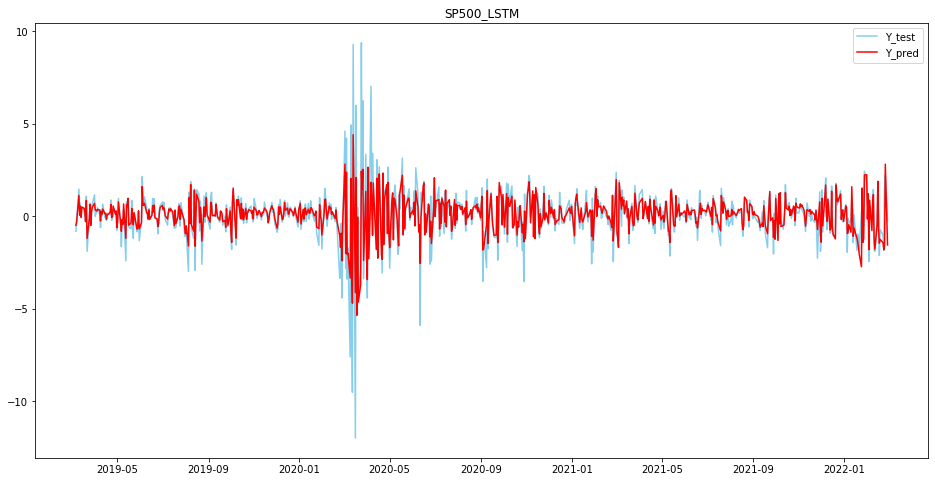

In [24]:
y_pred = model.predict(X_test)
metric_dict = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    }
print(metric_dict)

data_index = data_index[-len(y_test):]

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(data_index, y_test, label='Y_test', color='skyblue')
ax.plot(data_index, y_pred, label='Y_pred', color='red')
ax.set_title('SP500' + '_' + 'LSTM')
ax.legend()

plt.show()

In [25]:
result = pd.DataFrame(index = data_index)
result['SP500'] = y_pred

In [27]:
the_mem_days = 5
the_lstm_layers = 1
the_dense_layers = 1
the_units = 32

X_train, X_valid, X_test, y_train, y_valid, y_test, data_index = Stock_Price_LSTM_Data_Processing(Nasdaq_data, 'Nasdaq', the_mem_days)
                      
model = Sequential()
model.add(LSTM(the_units,input_shape=X_train.shape[1:],activation='relu',return_sequences=True))
model.add(Dropout(0.3))                
                
for i in range(the_lstm_layers):
    model.add(LSTM(the_units,activation='relu',return_sequences=True))
    model.add(Dropout(0.3))

model.add(LSTM(the_units,activation='relu'))
model.add(Dropout(0.3))

for i in range(the_dense_layers):
    model.add(Dense(the_units,activation='relu'))
    model.add(Dropout(0.3))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse',metrics=['mape'])

model.fit(X_train,y_train,batch_size=128,epochs=100,validation_data=(X_valid,y_valid))

/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Train on 1403 samples, validate on 351 samples
Epoch 1/100
1403/1403 [==============================] - 6s 4ms/sample - loss: 0.8733 - mape: 106.9669 - val_loss: 1.7202 - val_mape: 110.8619
Epoch 2/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.8693 - mape: 113.1391 - val_loss: 1.7192 - val_mape: 117.8669
Epoch 3/100
1403/1403 [==============================] - 1s 1ms/sample - loss: 0.8694 - mape: 116.3956 - val_loss: 1.7178 - val_mape: 125.7903
Epoch 4/100
1403/1403 [==============================] - 1s 787us/sample - loss: 0.8715 - mape: 119.8285 - val_loss: 1.7166 - val_mape: 136.6771
Epoch 5/100
1403/1403 [==============================] - 1s 940us/sample - loss: 0.8688 - mape: 124.2174 - val_loss: 1.7162 - val_mape: 136.6998
Epoch 6/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.8692 - mape: 121.2027 - val_loss: 1.7156 - val_mape: 132.0851
Epoch 7/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.8650 - map

1403/1403 [==============================] - 2s 2ms/sample - loss: 0.2053 - mape: 193.6289 - val_loss: 0.4037 - val_mape: 287.8742
Epoch 58/100
1403/1403 [==============================] - 2s 2ms/sample - loss: 0.1891 - mape: 186.3811 - val_loss: 0.3510 - val_mape: 280.6744
Epoch 59/100
1403/1403 [==============================] - 2s 2ms/sample - loss: 0.1957 - mape: 160.9899 - val_loss: 0.3339 - val_mape: 268.5604
Epoch 60/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.2196 - mape: 146.0831 - val_loss: 0.3815 - val_mape: 283.7610
Epoch 61/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.1971 - mape: 186.1850 - val_loss: 0.3995 - val_mape: 265.3835
Epoch 62/100
1403/1403 [==============================] - 2s 2ms/sample - loss: 0.1670 - mape: 156.9441 - val_loss: 0.3537 - val_mape: 294.3994
Epoch 63/100
1403/1403 [==============================] - 2s 2ms/sample - loss: 0.1790 - mape: 165.0081 - val_loss: 0.3480 - val_mape: 273.8713
Epoch

{'MAE': 0.5224611980972799, 'R2': 0.7113316346352572, 'MAPE': 1.3424553122026388, 'MSE': 0.7755501752682898}


/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


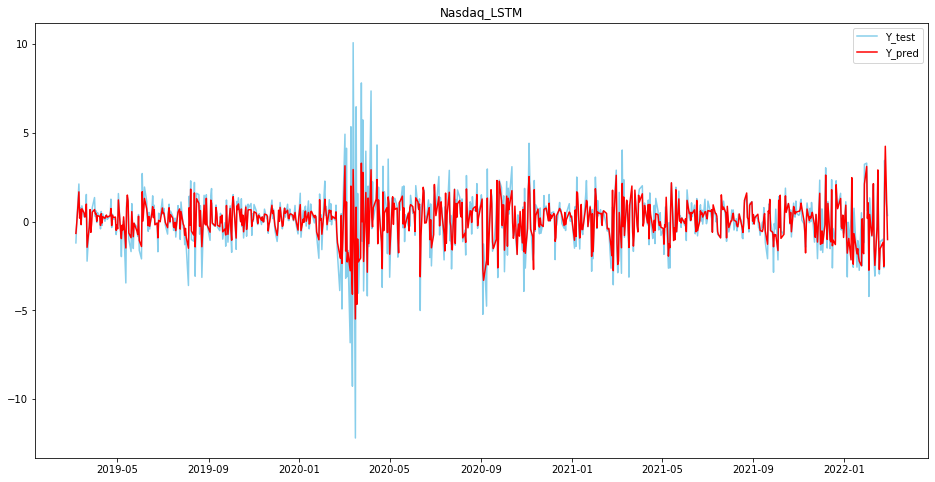

In [28]:
y_pred = model.predict(X_test)
metric_dict = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    }
print(metric_dict)

data_index = data_index[-len(y_test):]

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(data_index, y_test, label='Y_test', color='skyblue')
ax.plot(data_index, y_pred, label='Y_pred', color='red')
ax.set_title('Nasdaq' + '_' + 'LSTM')
ax.legend()

plt.show()

In [29]:
result['Nasdaq'] = y_pred

In [30]:
the_mem_days = 5
the_lstm_layers = 1
the_dense_layers = 1
the_units = 32

X_train, X_valid, X_test, y_train, y_valid, y_test, data_index = Stock_Price_LSTM_Data_Processing(DJ_data, 'DJ', the_mem_days)
                      
model = Sequential()
model.add(LSTM(the_units,input_shape=X_train.shape[1:],activation='relu',return_sequences=True))
model.add(Dropout(0.3))                
                
for i in range(the_lstm_layers):
    model.add(LSTM(the_units,activation='relu',return_sequences=True))
    model.add(Dropout(0.3))

model.add(LSTM(the_units,activation='relu'))
model.add(Dropout(0.3))

for i in range(the_dense_layers):
    model.add(Dense(the_units,activation='relu'))
    model.add(Dropout(0.3))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse',metrics=['mape'])

model.fit(X_train,y_train,batch_size=128,epochs=100,validation_data=(X_valid,y_valid))

/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Train on 1403 samples, validate on 351 samples
Epoch 1/100
1403/1403 [==============================] - 6s 4ms/sample - loss: 0.5545 - mape: 3084.9963 - val_loss: 1.0467 - val_mape: 101.1603
Epoch 2/100
1403/1403 [==============================] - 2s 2ms/sample - loss: 0.5529 - mape: 18667.3848 - val_loss: 1.0451 - val_mape: 105.0587
Epoch 3/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.5513 - mape: 866.4229 - val_loss: 1.0443 - val_mape: 107.3282
Epoch 4/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.5498 - mape: 17346.1016 - val_loss: 1.0435 - val_mape: 108.3074
Epoch 5/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.5517 - mape: 29201.2383 - val_loss: 1.0430 - val_mape: 110.0062
Epoch 6/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.5502 - mape: 16393.8438 - val_loss: 1.0421 - val_mape: 111.1969
Epoch 7/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.5516 

Epoch 57/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.1119 - mape: 10521.0752 - val_loss: 0.2050 - val_mape: 134.2161
Epoch 58/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.1311 - mape: 49905.1172 - val_loss: 0.2422 - val_mape: 134.5341
Epoch 59/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.1164 - mape: 87442.6719 - val_loss: 0.2315 - val_mape: 125.2404
Epoch 60/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.1183 - mape: 40930.8750 - val_loss: 0.2435 - val_mape: 122.3740
Epoch 61/100
1403/1403 [==============================] - 1s 997us/sample - loss: 0.1111 - mape: 199728.3594 - val_loss: 0.2255 - val_mape: 132.4582
Epoch 62/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.1153 - mape: 60334.4023 - val_loss: 0.2194 - val_mape: 131.5864
Epoch 63/100
1403/1403 [==============================] - 2s 1ms/sample - loss: 0.0976 - mape: 193919.7500 - val_loss: 0.

{'MAE': 0.36161724033617954, 'R2': 0.7437963629735691, 'MAPE': 814879911503.6903, 'MSE': 0.5653605784226595}


/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Users/darrenh/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


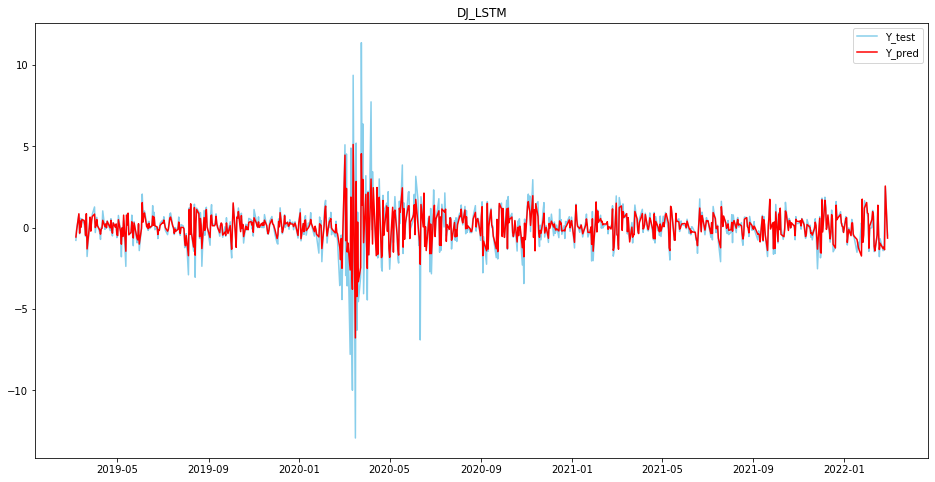

In [31]:
y_pred = model.predict(X_test)
metric_dict = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    }
print(metric_dict)

data_index = data_index[-len(y_test):]

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(data_index, y_test, label='Y_test', color='skyblue')
ax.plot(data_index, y_pred, label='Y_pred', color='red')
ax.set_title('DJ' + '_' + 'LSTM')
ax.legend()

plt.show()

In [32]:
result['DJ'] = y_pred

In [33]:
result.to_csv('./result.csv')

In [26]:
data_index

DatetimeIndex(['2019-03-07', '2019-03-08', '2019-03-11', '2019-03-12',
               '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-18',
               '2019-03-19', '2019-03-20',
               ...
               '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
               '2022-02-18', '2022-02-22', '2022-02-23', '2022-02-24',
               '2022-02-25', '2022-02-28'],
              dtype='datetime64[ns]', length=752, freq=None)